## NN

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Load the dataset
file_path = '/kaggle/input/gym-exercise-data/megaGymDataset.csv'
exercise_df = pd.read_csv(file_path)

# Display the first few rows of the dataset
print("First 5 rows of the dataset:")
print(exercise_df.head())

# Check for missing values
print("\nMissing values in the dataset:")
print(exercise_df.isnull().sum())

# Handle missing values
exercise_df['Rating'] = pd.to_numeric(exercise_df['Rating'], errors='coerce')  # Convert non-numeric to NaN
exercise_df['Rating'].fillna(0, inplace=True)  # Fill missing ratings with 0
exercise_df.dropna(subset=['Title'], inplace=True)  # Drop rows where Title is missing

# Encode categorical features
label_encoder_type = LabelEncoder()
label_encoder_bodypart = LabelEncoder()
label_encoder_equipment = LabelEncoder()
label_encoder_level = LabelEncoder()
label_encoder_title = LabelEncoder()

exercise_df['Type_encoded'] = label_encoder_type.fit_transform(exercise_df['Type'])
exercise_df['BodyPart_encoded'] = label_encoder_bodypart.fit_transform(exercise_df['BodyPart'])
exercise_df['Equipment_encoded'] = label_encoder_equipment.fit_transform(exercise_df['Equipment'])
exercise_df['Level_encoded'] = label_encoder_level.fit_transform(exercise_df['Level'])
exercise_df['Title_encoded'] = label_encoder_title.fit_transform(exercise_df['Title'])

# Normalize the Rating column
scaler = MinMaxScaler()
exercise_df['Rating_scaled'] = scaler.fit_transform(exercise_df[['Rating']])

# Prepare features and labels
X = exercise_df[['Type_encoded', 'BodyPart_encoded', 'Equipment_encoded', 'Level_encoded', 'Rating_scaled']].values
y = exercise_df['Title_encoded'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"\nTraining set size: {X_train.shape[0]}, Test set size: {X_test.shape[0]}")


First 5 rows of the dataset:
   Unnamed: 0                         Title  \
0           0        Partner plank band row   
1           1  Banded crunch isometric hold   
2           2         FYR Banded Plank Jack   
3           3                 Banded crunch   
4           4                        Crunch   

                                                Desc      Type    BodyPart  \
0  The partner plank band row is an abdominal exe...  Strength  Abdominals   
1  The banded crunch isometric hold is an exercis...  Strength  Abdominals   
2  The banded plank jack is a variation on the pl...  Strength  Abdominals   
3  The banded crunch is an exercise targeting the...  Strength  Abdominals   
4  The crunch is a popular core exercise targetin...  Strength  Abdominals   

  Equipment         Level  Rating RatingDesc  
0     Bands  Intermediate     0.0        NaN  
1     Bands  Intermediate     NaN        NaN  
2     Bands  Intermediate     NaN        NaN  
3     Bands  Intermediate     N

/tmp/ipykernel_23/689030108.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  exercise_df['Rating'].fillna(0, inplace=True)  # Fill missing ratings with 0


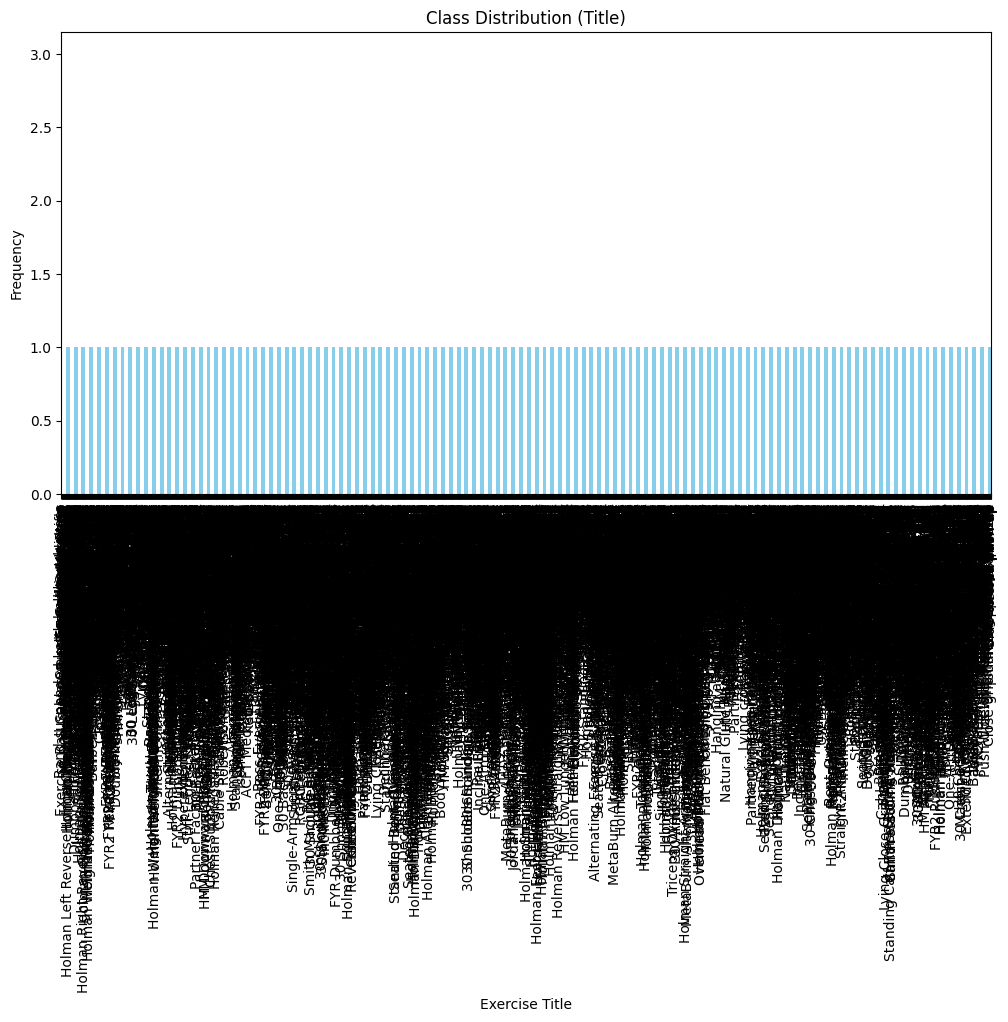


Sample from each class:
                                Unnamed: 0  \
Title                                        
1.5-rep push-up                       1044   
3/4 sit-up                             198   
30 Arms BFR Close-Grip Push-Up        2909   
30 Arms BFR Dumbbell Kick-Back        2823   
30 Arms BFR High Cable Curl            844   
...                                    ...   
Yates Row                             1645   
Yates Row Reverse Grip                1641   
Yoga plex                             1602   
Yoke Walk                             2005   
Zercher squat                         1823   

                                                                             Desc  \
Title                                                                               
1.5-rep push-up                 The 1.5-rep push-up is a more difficult variat...   
3/4 sit-up                      The 3/4 sit-up is a bodyweight exercise focuse...   
30 Arms BFR Close-Grip Push-Up      

In [2]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(12, 6))
exercise_df['Title'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Class Distribution (Title)")
plt.xlabel("Exercise Title")
plt.ylabel("Frequency")
plt.show()

# Display one sample for each class
print("\nSample from each class:")
print(exercise_df.groupby('Title').first())


In [3]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2

# Define the Neural Network model
def create_neural_network(input_shape, num_classes, dropout_rate=0.3, l2_reg=0.01):
    model = Sequential([
        Dense(128, activation='relu', input_shape=(input_shape,), kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')  # Output layer for multi-class classification
    ])
    return model


In [4]:
# Define hyperparameters
dropout_rate = 0.3
l2_reg = 0.01

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Create the model
num_classes = len(label_encoder_title.classes_)
nn_model = create_neural_network(input_shape=X_train.shape[1], num_classes=num_classes, dropout_rate=dropout_rate, l2_reg=l2_reg)

# Compile the model
nn_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('nn_model.keras', save_best_only=True, monitor='val_loss')

# Train the model
history = nn_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])


Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - accuracy: 0.0000e+00 - loss: 8.8466 - val_accuracy: 0.0000e+00 - val_loss: 8.5765
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0025 - loss: 8.4100 - val_accuracy: 0.0000e+00 - val_loss: 8.4169
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0059 - loss: 8.0927 - val_accuracy: 0.0021 - val_loss: 8.3804
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0036 - loss: 7.7925 - val_accuracy: 0.0021 - val_loss: 8.5317
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0062 - loss: 7.4456 - val_accuracy: 0.0021 - val_loss: 8.9007
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0103 - loss: 7.0704 - val_accuracy: 0.0021 - val_loss: 9.5617
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0227 - loss: 6.7393 - val_accuracy: 0.0021 - val_loss: 10.3203
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0122 - loss: 6.4929 - val_accuracy: 0.00

Test Loss: 8.3826, Test Accuracy: 0.17%


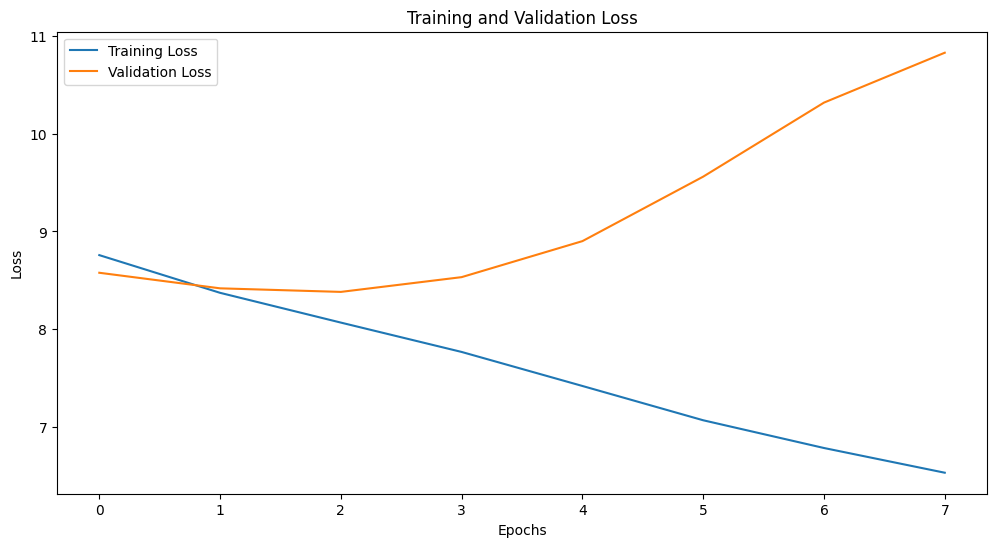

In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = nn_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2%}")

# Visualize training history
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [10]:
# Adjust hyperparameters for comparison
configs = [
    {'dropout_rate': 0.2, 'l2_reg': 0.01, 'learning_rate': 0.001},
    {'dropout_rate': 0.3, 'l2_reg': 0.001, 'learning_rate': 0.0005},
    {'dropout_rate': 0.4, 'l2_reg': 0.01, 'learning_rate': 0.01}
]

# Train and evaluate models with different configurations
results = []
for config in configs:
    print(f"Training with config: {config}")
    model = create_neural_network(input_shape=X_train.shape[1], num_classes=num_classes, 
                                   dropout_rate=config['dropout_rate'], l2_reg=config['l2_reg'])
    model.compile(optimizer=Adam(learning_rate=config['learning_rate']), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    results.append({'config': config, 'test_loss': test_loss, 'test_accuracy': test_accuracy})

# Display results
for result in results:
    print(f"Config: {result['config']}, Test Loss: {result['test_loss']:.4f}, Test Accuracy: {result['test_accuracy']:.2%}")


Training with config: {'dropout_rate': 0.2, 'l2_reg': 0.01, 'learning_rate': 0.001}
Training with config: {'dropout_rate': 0.3, 'l2_reg': 0.001, 'learning_rate': 0.0005}
Training with config: {'dropout_rate': 0.4, 'l2_reg': 0.01, 'learning_rate': 0.01}
Config: {'dropout_rate': 0.2, 'l2_reg': 0.01, 'learning_rate': 0.001}, Test Loss: 8.3683, Test Accuracy: 0.17%
Config: {'dropout_rate': 0.3, 'l2_reg': 0.001, 'learning_rate': 0.0005}, Test Loss: 8.0771, Test Accuracy: 0.00%
Config: {'dropout_rate': 0.4, 'l2_reg': 0.01, 'learning_rate': 0.01}, Test Loss: 8.4229, Test Accuracy: 0.00%


In [11]:
# Decode labels back to original values for interpretation
decoded_y_test = label_encoder_title.inverse_transform(y_test)  # True labels
decoded_y_pred = label_encoder_title.inverse_transform(np.argmax(nn_model.predict(X_test), axis=1))  # Predicted labels

# Select a random subset of test samples
import random
random_indices = random.sample(range(len(X_test)), 10)

print("\nSample Predictions:")
print("------------------------------------------------------")
for i in random_indices:
    # Display user preferences
    input_features = X_test[i]
    decoded_type = label_encoder_type.inverse_transform([int(input_features[0])])[0]
    decoded_bodypart = label_encoder_bodypart.inverse_transform([int(input_features[1])])[0]
    decoded_equipment = label_encoder_equipment.inverse_transform([int(input_features[2])])[0]
    decoded_level = label_encoder_level.inverse_transform([int(input_features[3])])[0]
    rating = input_features[4]

    print(f"Input {i + 1}:")
    print(f"  Type: {decoded_type}")
    print(f"  Body Part: {decoded_bodypart}")
    print(f"  Equipment: {decoded_equipment}")
    print(f"  Level: {decoded_level}")
    print(f"  Rating: {rating:.2f}")

    # Display true and predicted outputs
    print(f"  True Exercise: {decoded_y_test[i]}")
    print(f"  Predicted Exercise: {decoded_y_pred[i]}")
    print("------------------------------------------------------")


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Sample Predictions:
------------------------------------------------------
Input 288:
  Type: Strength
  Body Part: Biceps
  Equipment: Dumbbell
  Level: Intermediate
  Rating: 0.00
  True Exercise: 30 Arms Standing Dumbbell Hammer Curl 21s
  Predicted Exercise: MetaBurn Biceps Curl To Lateral Raise
------------------------------------------------------
Input 286:
  Type: Strength
  Body Part: Biceps
  Equipment: Dumbbell
  Level: Intermediate
  Rating: 0.00
  True Exercise: TBS Incline Dumbbell Curl
  Predicted Exercise: MetaBurn Biceps Curl To Lateral Raise
------------------------------------------------------
Input 579:
  Type: Strength
  Body Part: Triceps
  Equipment: E-Z Curl Bar
  Level: Intermediate
  Rating: 0.00
  True Exercise: 30 Arms EZ-Bar Skullcrusher
  Predicted Exercise: Overhead dumbbell front raise
------------------------------------------------------
Input 541:
  Type: Strength
  Body Part: Shoulders
  Equipment: Dumbbell
 

In [12]:
# Generate predictions for a specific user input
user_input = np.array([[0, 3, 2, 1, 0.8]])  # Example user preferences
user_decoded_type = label_encoder_type.inverse_transform([int(user_input[0, 0])])[0]
user_decoded_bodypart = label_encoder_bodypart.inverse_transform([int(user_input[0, 1])])[0]
user_decoded_equipment = label_encoder_equipment.inverse_transform([int(user_input[0, 2])])[0]
user_decoded_level = label_encoder_level.inverse_transform([int(user_input[0, 3])])[0]

predicted_exercise_idx = np.argmax(nn_model.predict(user_input), axis=1)
predicted_exercise = label_encoder_title.inverse_transform(predicted_exercise_idx)

print("\nUser Input Preferences:")
print(f"  Type: {user_decoded_type}")
print(f"  Body Part: {user_decoded_bodypart}")
print(f"  Equipment: {user_decoded_equipment}")
print(f"  Level: {user_decoded_level}")
print(f"  Rating: {user_input[0, 4]:.2f}")
print("\nGenerated Exercise Recommendation:")
print(f"  Predicted Exercise: {predicted_exercise[0]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step

User Input Preferences:
  Type: Cardio
  Body Part: Biceps
  Equipment: Body Only
  Level: Expert
  Rating: 0.80

Generated Exercise Recommendation:
  Predicted Exercise: HM Air Jumping Rope


## CGAN

In [13]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1. Data Loading and Preprocessing
# Load the dataset
file_path = '/kaggle/input/gym-exercise-data/megaGymDataset.csv'
exercise_df = pd.read_csv(file_path)

# Display the first few rows
print("First 5 rows of the dataset:")
print(exercise_df.head())

# Check for missing values
print("\nMissing values in the dataset:")
print(exercise_df.isnull().sum())

# Handle missing values
exercise_df['Rating'] = pd.to_numeric(exercise_df['Rating'], errors='coerce')  # Convert non-numeric to NaN
exercise_df['Rating'].fillna(0, inplace=True)  # Fill missing ratings with 0
exercise_df.dropna(subset=['Title'], inplace=True)  # Drop rows where Title is missing

# Encode categorical features
label_encoder_type = LabelEncoder()
label_encoder_bodypart = LabelEncoder()
label_encoder_equipment = LabelEncoder()
label_encoder_title = LabelEncoder()

exercise_df['Type_encoded'] = label_encoder_type.fit_transform(exercise_df['Type'])
exercise_df['BodyPart_encoded'] = label_encoder_bodypart.fit_transform(exercise_df['BodyPart'])
exercise_df['Equipment_encoded'] = label_encoder_equipment.fit_transform(exercise_df['Equipment'])
exercise_df['Title_encoded'] = label_encoder_title.fit_transform(exercise_df['Title'])

# Normalize the Rating column
scaler = MinMaxScaler()
exercise_df['Rating_scaled'] = scaler.fit_transform(exercise_df[['Rating']])

# Features (conditions)
conditions = exercise_df[['Type_encoded', 'BodyPart_encoded', 'Equipment_encoded', 'Rating_scaled']].values

# Labels (exercise titles)
labels = exercise_df['Title_encoded'].values

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(conditions, labels, test_size=0.2, random_state=42)

print("\nData preprocessing complete.")

First 5 rows of the dataset:
   Unnamed: 0                         Title  \
0           0        Partner plank band row   
1           1  Banded crunch isometric hold   
2           2         FYR Banded Plank Jack   
3           3                 Banded crunch   
4           4                        Crunch   

                                                Desc      Type    BodyPart  \
0  The partner plank band row is an abdominal exe...  Strength  Abdominals   
1  The banded crunch isometric hold is an exercis...  Strength  Abdominals   
2  The banded plank jack is a variation on the pl...  Strength  Abdominals   
3  The banded crunch is an exercise targeting the...  Strength  Abdominals   
4  The crunch is a popular core exercise targetin...  Strength  Abdominals   

  Equipment         Level  Rating RatingDesc  
0     Bands  Intermediate     0.0        NaN  
1     Bands  Intermediate     NaN        NaN  
2     Bands  Intermediate     NaN        NaN  
3     Bands  Intermediate     N

/tmp/ipykernel_23/937390230.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  exercise_df['Rating'].fillna(0, inplace=True)  # Fill missing ratings with 0


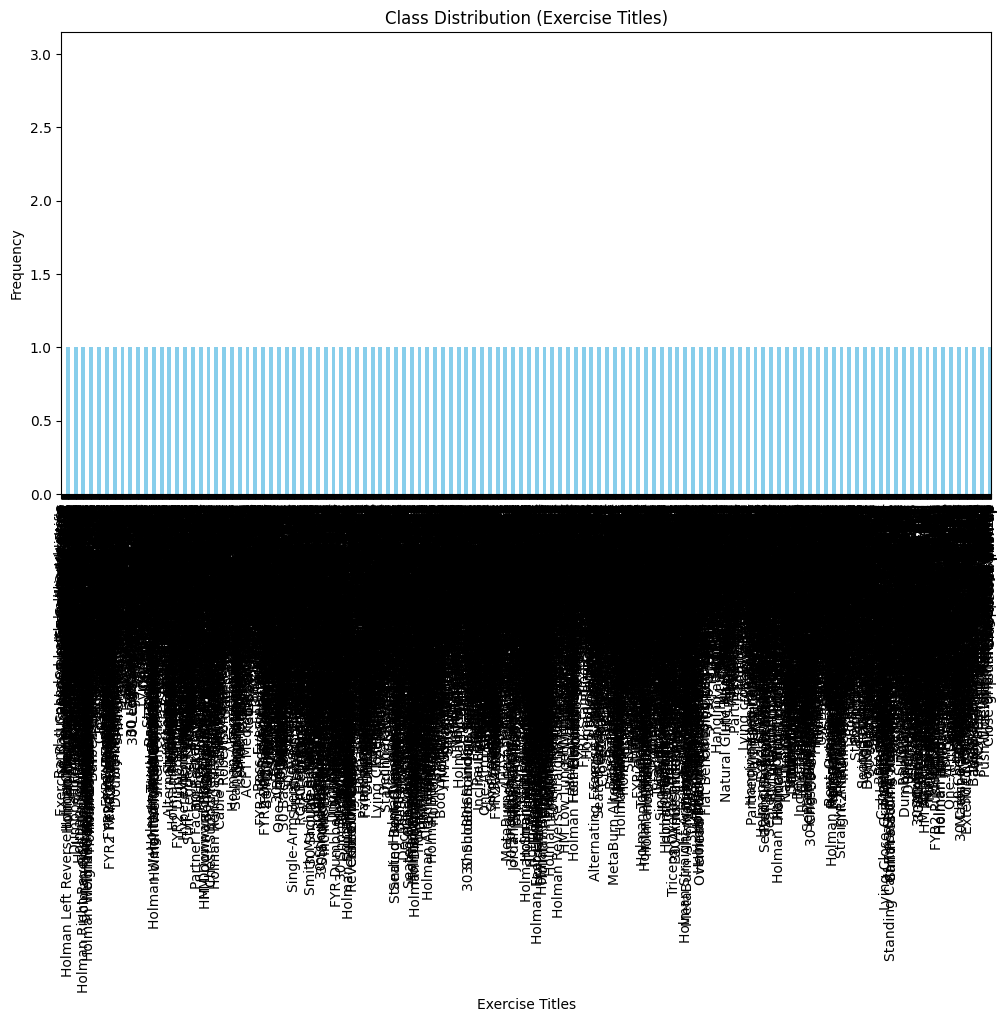


Sample from each class:
                                Unnamed: 0  \
Title                                        
1.5-rep push-up                       1044   
3/4 sit-up                             198   
30 Arms BFR Close-Grip Push-Up        2909   
30 Arms BFR Dumbbell Kick-Back        2823   
30 Arms BFR High Cable Curl            844   
...                                    ...   
Yates Row                             1645   
Yates Row Reverse Grip                1641   
Yoga plex                             1602   
Yoke Walk                             2005   
Zercher squat                         1823   

                                                                             Desc  \
Title                                                                               
1.5-rep push-up                 The 1.5-rep push-up is a more difficult variat...   
3/4 sit-up                      The 3/4 sit-up is a bodyweight exercise focuse...   
30 Arms BFR Close-Grip Push-Up      

In [14]:
# 2. Data Visualization
# Plot class distribution
plt.figure(figsize=(12, 6))
exercise_df['Title'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Class Distribution (Exercise Titles)")
plt.xlabel("Exercise Titles")
plt.ylabel("Frequency")
plt.show()

# Display one sample for each class
print("\nSample from each class:")
print(exercise_df.groupby('Title').first())

In [15]:
# 3. Model Architecture
# Generator
def build_generator(latent_dim, condition_dim, output_dim):
    noise_input = Input(shape=(latent_dim,), name="noise_input")
    condition_input = Input(shape=(condition_dim,), name="condition_input")
    
    x = Concatenate()([noise_input, condition_input])
    x = Dense(128, activation='relu')(x)
    x = Dense(256, activation='relu')(x)
    x = Dense(512, activation='relu')(x)
    output = Dense(output_dim, activation='softmax')(x)  # One-hot encoded exercise title
    
    return Model([noise_input, condition_input], output, name="Generator")

# Discriminator
def build_discriminator(condition_dim, output_dim):
    model = Sequential([
        Input(shape=(condition_dim + output_dim,)),
        Dense(512, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(1, activation='sigmoid')  # Real or Fake
    ])
    return model

# Model Parameters
latent_dim = 10  # Noise dimension
condition_dim = conditions.shape[1]
output_dim = len(label_encoder_title.classes_)

# Build generator and discriminator
generator = build_generator(latent_dim, condition_dim, output_dim)
discriminator = build_discriminator(condition_dim, output_dim)
discriminator.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# GAN
noise_input = Input(shape=(latent_dim,))
condition_input = Input(shape=(condition_dim,))
generated_output = generator([noise_input, condition_input])

discriminator.trainable = False
discriminator_input = Concatenate()([generated_output, condition_input])
validity = discriminator(discriminator_input)

gan = Model([noise_input, condition_input], validity)
gan.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

In [16]:
# 4. Hyperparameter Tuning
epochs = 1000
batch_size = 32

# 5. Model Training
d_losses, g_losses = [], []
for epoch in range(epochs):
    # Prepare real data
    idx = np.random.randint(0, X_train.shape[0], batch_size)
    real_conditions = X_train[idx]
    real_labels = y_train[idx]
    real_labels_onehot = np.eye(output_dim)[real_labels]
    real_data = np.hstack((real_labels_onehot, real_conditions))
    real_targets = np.ones((batch_size, 1))  # Label as real

    # Generate fake data
    noise = np.random.normal(0, 1, (batch_size, latent_dim))
    fake_labels = generator.predict([noise, real_conditions])
    fake_data = np.hstack((fake_labels, real_conditions))
    fake_targets = np.zeros((batch_size, 1))  # Label as fake

    # Train discriminator
    d_loss_real = discriminator.train_on_batch(real_data, real_targets)
    d_loss_fake = discriminator.train_on_batch(fake_data, fake_targets)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    # Train generator
    misleading_targets = np.ones((batch_size, 1))
    g_loss = gan.train_on_batch([noise, real_conditions], misleading_targets)

    d_losses.append(d_loss[0])
    g_losses.append(g_loss)

    # Print progress
    if epoch % 100 == 0:
        d_loss_value = d_loss[0] if isinstance(d_loss, (list, tuple, np.ndarray)) else d_loss
        d_accuracy_value = d_loss[1] if isinstance(d_loss, (list, tuple, np.ndarray)) else 0  # Only for discriminator
        g_loss_value = g_loss[0] if isinstance(g_loss, (list, tuple, np.ndarray)) else g_loss

        print(f"Epoch {epoch}/{epochs} - D Loss: {d_loss_value:.4f}, D Accuracy: {d_accuracy_value:.2f}, G Loss: {g_loss_value:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step


/opt/conda/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py:71: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


Epoch 0/1000 - D Loss: 0.7303, D Accuracy: 0.32, G Loss: 0.6959
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━

In [17]:
# Example conditions for multiple users
sample_conditions = np.array([
    [0, 2, 1, 0.7],  # Type=0, BodyPart=2, Equipment=1, Rating=0.7
    [1, 4, 3, 0.6],  # Type=1, BodyPart=4, Equipment=3, Rating=0.6
    [2, 1, 0, 0.9],  # Type=2, BodyPart=1, Equipment=0, Rating=0.9
    [3, 0, 2, 0.8],  # Type=3, BodyPart=0, Equipment=2, Rating=0.8
    [1, 3, 4, 0.5]   # Type=1, BodyPart=3, Equipment=4, Rating=0.5
])

# Loop through each condition
for i, condition in enumerate(sample_conditions):
    # Decode the input condition
    decoded_type = label_encoder_type.inverse_transform([int(condition[0])])[0]
    decoded_bodypart = label_encoder_bodypart.inverse_transform([int(condition[1])])[0]
    decoded_equipment = label_encoder_equipment.inverse_transform([int(condition[2])])[0]

    print(f"\nInput Condition for User {i+1}:")
    print(f"  Exercise Type: {decoded_type}")
    print(f"  Targeted Body Part: {decoded_bodypart}")
    print(f"  Equipment: {decoded_equipment}")
    print(f"  Rating (scaled): {condition[3]}")

    # Generate noise
    noise = np.random.normal(0, 1, (1, latent_dim))

    # Generate the exercise recommendation
    generated_label = generator.predict([noise, condition.reshape(1, -1)])
    predicted_exercise_idx = np.argmax(generated_label, axis=1)
    predicted_exercise = label_encoder_title.inverse_transform(predicted_exercise_idx)

    # Display the generated exercise
    print(f"  Predicted Exercise: {predicted_exercise[0]}")



Input Condition for User 1:
  Exercise Type: Cardio
  Targeted Body Part: Adductors
  Equipment: Barbell
  Rating (scaled): 0.7
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step
  Predicted Exercise: Barbell Squat To A Box

Input Condition for User 2:
  Exercise Type: Olympic Weightlifting
  Targeted Body Part: Calves
  Equipment: Cable
  Rating (scaled): 0.6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
  Predicted Exercise: Dumbbell clean and push-press

Input Condition for User 3:
  Exercise Type: Plyometrics
  Targeted Body Part: Abductors
  Equipment: Bands
  Rating (scaled): 0.9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
  Predicted Exercise: 30 Back T-Bar Row

Input Condition for User 4:
  Exercise Type: Powerlifting
  Targeted Body Part: Abdominals
  Equipment: Body Only
  Rating (scaled): 0.8
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
  Predicted Exercise: Overhead Stretch

Input Condition for User 5:
  Exercise Type: Olympic Weightlifting
  Targeted Body Part: Biceps
  Equipment: Dumbbell
  Rating (scal

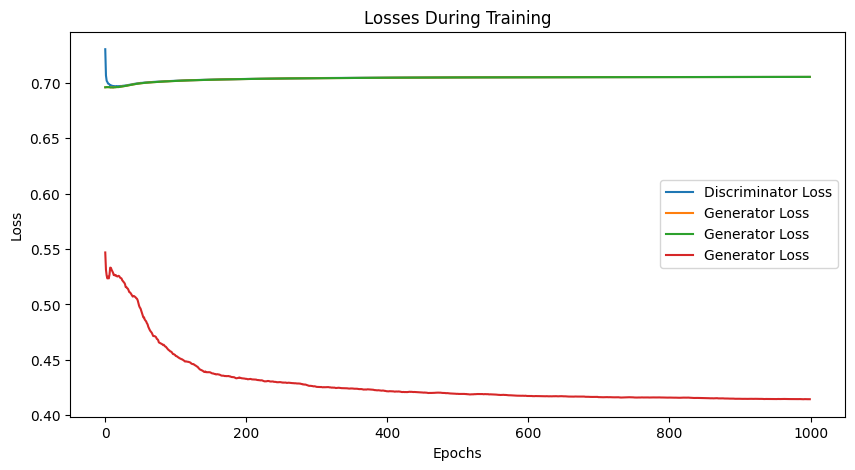

In [18]:
# Plot discriminator and generator losses
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label='Discriminator Loss')
plt.plot(g_losses, label='Generator Loss')
plt.title('Losses During Training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## VAE

In [19]:
# Import libraries
import pandas as pd
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import numpy as np

# Load the dataset
file_path = '/kaggle/input/gym-exercise-data/megaGymDataset.csv'
exercise_df = pd.read_csv(file_path)

# Display the first few rows
print("First 5 rows of the dataset:")
print(exercise_df.head())

# Check for missing values
print("\nMissing values in the dataset:")
print(exercise_df.isnull().sum())

# Handle missing values
exercise_df['Rating'] = pd.to_numeric(exercise_df['Rating'], errors='coerce')  # Convert non-numeric to NaN
exercise_df['Rating'].fillna(0, inplace=True)  # Fill missing ratings with 0
exercise_df.dropna(subset=['Title'], inplace=True)  # Drop rows where Title is missing

# Encode categorical features
label_encoder_type = LabelEncoder()
label_encoder_bodypart = LabelEncoder()
label_encoder_equipment = LabelEncoder()
label_encoder_title = LabelEncoder()

exercise_df['Type_encoded'] = label_encoder_type.fit_transform(exercise_df['Type'])
exercise_df['BodyPart_encoded'] = label_encoder_bodypart.fit_transform(exercise_df['BodyPart'])
exercise_df['Equipment_encoded'] = label_encoder_equipment.fit_transform(exercise_df['Equipment'])
exercise_df['Title_encoded'] = label_encoder_title.fit_transform(exercise_df['Title'])

# Normalize the Rating column
scaler = MinMaxScaler()
exercise_df['Rating_scaled'] = scaler.fit_transform(exercise_df[['Rating']])

# Features (conditions)
features = exercise_df[['Type_encoded', 'BodyPart_encoded', 'Equipment_encoded', 'Rating_scaled']].values

# Labels (exercise titles)
labels = exercise_df['Title_encoded'].values

print("\nData preprocessing complete.")


First 5 rows of the dataset:
   Unnamed: 0                         Title  \
0           0        Partner plank band row   
1           1  Banded crunch isometric hold   
2           2         FYR Banded Plank Jack   
3           3                 Banded crunch   
4           4                        Crunch   

                                                Desc      Type    BodyPart  \
0  The partner plank band row is an abdominal exe...  Strength  Abdominals   
1  The banded crunch isometric hold is an exercis...  Strength  Abdominals   
2  The banded plank jack is a variation on the pl...  Strength  Abdominals   
3  The banded crunch is an exercise targeting the...  Strength  Abdominals   
4  The crunch is a popular core exercise targetin...  Strength  Abdominals   

  Equipment         Level  Rating RatingDesc  
0     Bands  Intermediate     0.0        NaN  
1     Bands  Intermediate     NaN        NaN  
2     Bands  Intermediate     NaN        NaN  
3     Bands  Intermediate     N

/tmp/ipykernel_23/3256829938.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  exercise_df['Rating'].fillna(0, inplace=True)  # Fill missing ratings with 0


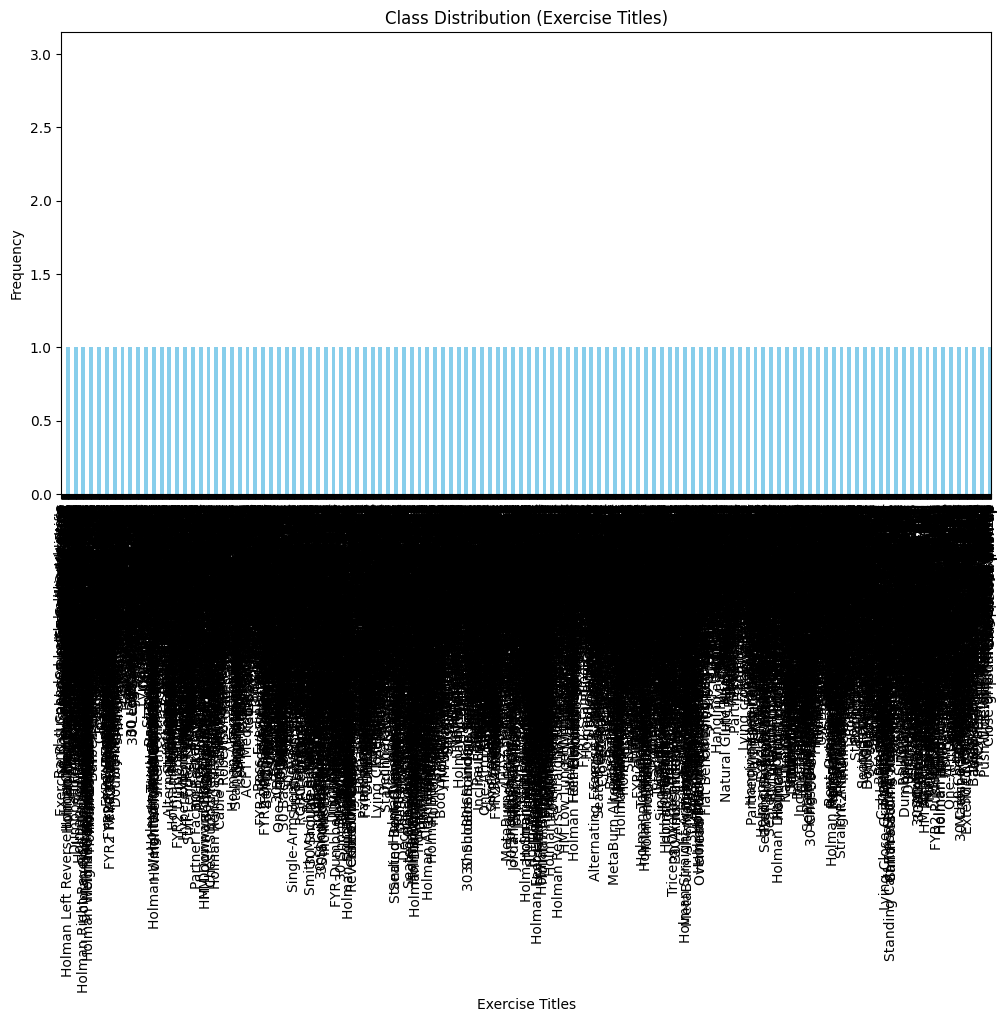


Sample from each class:
                                Unnamed: 0  \
Title                                        
1.5-rep push-up                       1044   
3/4 sit-up                             198   
30 Arms BFR Close-Grip Push-Up        2909   
30 Arms BFR Dumbbell Kick-Back        2823   
30 Arms BFR High Cable Curl            844   
...                                    ...   
Yates Row                             1645   
Yates Row Reverse Grip                1641   
Yoga plex                             1602   
Yoke Walk                             2005   
Zercher squat                         1823   

                                                                             Desc  \
Title                                                                               
1.5-rep push-up                 The 1.5-rep push-up is a more difficult variat...   
3/4 sit-up                      The 3/4 sit-up is a bodyweight exercise focuse...   
30 Arms BFR Close-Grip Push-Up      

In [20]:
import matplotlib.pyplot as plt

# Plot class distribution
plt.figure(figsize=(12, 6))
exercise_df['Title'].value_counts().plot(kind='bar', color='skyblue')
plt.title("Class Distribution (Exercise Titles)")
plt.xlabel("Exercise Titles")
plt.ylabel("Frequency")
plt.show()

# Display one sample for each class
print("\nSample from each class:")
print(exercise_df.groupby('Title').first())


In [22]:
from tensorflow.keras import Model, layers
from tensorflow.keras.regularizers import l1_l2

# Encoder with regularization and dropout
def build_encoder(input_dim, latent_dim):
    inputs = layers.Input(shape=(input_dim,), name="encoder_input")
    x = layers.Dense(128, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
    return Model(inputs, [z_mean, z_log_var], name="Encoder")

# Decoder with regularization and dropout
def build_decoder(latent_dim, output_dim):
    latent_inputs = layers.Input(shape=(latent_dim,), name="decoder_input")
    x = layers.Dense(64, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(latent_inputs)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(128, activation="relu", kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4))(x)
    outputs = layers.Dense(output_dim, activation="softmax")(x)
    return Model(latent_inputs, outputs, name="Decoder")

# Sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        epsilon = tf.keras.backend.random_normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [23]:
import tensorflow as tf
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Dimensions
input_dim = features.shape[1]
latent_dim = 10  # Dimension of the latent space
output_dim = len(label_encoder_title.classes_)

# Build encoder, sampling, and decoder
encoder = build_encoder(input_dim=input_dim, latent_dim=latent_dim)
decoder = build_decoder(latent_dim=latent_dim, output_dim=output_dim)
sampling_layer = Sampling()

# VAE Model with Flexible Output
class VAE(Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.reconstruction_loss_fn = SparseCategoricalCrossentropy()

    def call(self, inputs, training=False, return_latent=False):
        z_mean, z_log_var = self.encoder(inputs, training=training)
        z = sampling_layer([z_mean, z_log_var])
        outputs = self.decoder(z, training=training)
        if return_latent:
            return outputs, z_mean, z_log_var
        return outputs


In [24]:
# Compile VAE
vae = VAE(encoder, decoder)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=1.0)

# Custom training step
def train_step(inputs, labels):
    with tf.GradientTape() as tape:
        outputs, z_mean, z_log_var = vae(inputs, training=True, return_latent=True)
        # Reconstruction loss
        reconstruction_loss = tf.reduce_mean(vae.reconstruction_loss_fn(labels, outputs))
        # KL divergence loss
        kl_loss = -0.5 * tf.reduce_sum(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var), axis=-1)
        kl_loss = tf.reduce_mean(kl_loss)
        # Total loss
        total_loss = reconstruction_loss + kl_loss

    # Backpropagation
    gradients = tape.gradient(total_loss, vae.trainable_weights)
    optimizer.apply_gradients(zip(gradients, vae.trainable_weights))

    return total_loss, reconstruction_loss, kl_loss

# Training loop
epochs = 50
batch_size = 32
steps_per_epoch = features.shape[0] // batch_size

loss_history = {"total_loss": [], "reconstruction_loss": [], "kl_loss": []}

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    epoch_total_loss = 0
    epoch_reconstruction_loss = 0
    epoch_kl_loss = 0

    for step in range(steps_per_epoch):
        # Randomly sample a batch
        idx = np.random.randint(0, features.shape[0], batch_size)
        batch_inputs = features[idx]
        batch_labels = labels[idx]

        # Perform training step
        total_loss, reconstruction_loss, kl_loss = train_step(batch_inputs, batch_labels)

        # Accumulate losses
        epoch_total_loss += total_loss
        epoch_reconstruction_loss += reconstruction_loss
        epoch_kl_loss += kl_loss

    # Average losses over the epoch
    epoch_total_loss /= steps_per_epoch
    epoch_reconstruction_loss /= steps_per_epoch
    epoch_kl_loss /= steps_per_epoch

    loss_history["total_loss"].append(epoch_total_loss.numpy())
    loss_history["reconstruction_loss"].append(epoch_reconstruction_loss.numpy())
    loss_history["kl_loss"].append(epoch_kl_loss.numpy())

    print(
        f"Total Loss: {epoch_total_loss:.4f}, "
        f"Reconstruction Loss: {epoch_reconstruction_loss:.4f}, "
        f"KL Loss: {epoch_kl_loss:.4f}"
    )



Epoch 1/50
Total Loss: 8.9591, Reconstruction Loss: 7.9859, KL Loss: 0.9733

Epoch 2/50
Total Loss: 8.0088, Reconstruction Loss: 7.9880, KL Loss: 0.0208

Epoch 3/50
Total Loss: 7.9894, Reconstruction Loss: 7.9839, KL Loss: 0.0056

Epoch 4/50
Total Loss: 7.9826, Reconstruction Loss: 7.9798, KL Loss: 0.0028

Epoch 5/50
Total Loss: 7.9805, Reconstruction Loss: 7.9796, KL Loss: 0.0009

Epoch 6/50
Total Loss: 7.9801, Reconstruction Loss: 7.9794, KL Loss: 0.0006

Epoch 7/50
Total Loss: 7.9837, Reconstruction Loss: 7.9834, KL Loss: 0.0003

Epoch 8/50
Total Loss: 7.9777, Reconstruction Loss: 7.9774, KL Loss: 0.0003

Epoch 9/50
Total Loss: 7.9792, Reconstruction Loss: 7.9789, KL Loss: 0.0003

Epoch 10/50
Total Loss: 7.9789, Reconstruction Loss: 7.9787, KL Loss: 0.0002

Epoch 11/50
Total Loss: 7.9786, Reconstruction Loss: 7.9784, KL Loss: 0.0001

Epoch 12/50
Total Loss: 7.9813, Reconstruction Loss: 7.9811, KL Loss: 0.0001

Epoch 13/50
Total Loss: 7.9796, Reconstruction Loss: 7.9795, KL Loss: 0.

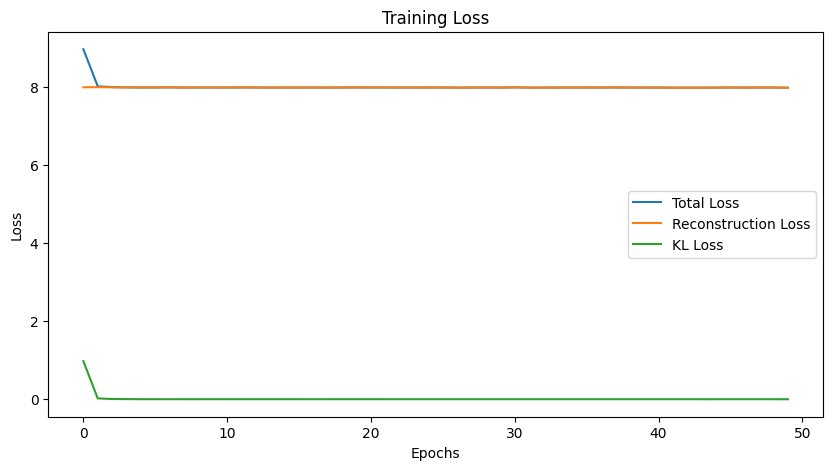

In [25]:
# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history["total_loss"], label="Total Loss")
plt.plot(loss_history["reconstruction_loss"], label="Reconstruction Loss")
plt.plot(loss_history["kl_loss"], label="KL Loss")
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


In [26]:
# Generate new exercises
sample_input = np.array([[1, 3, 2, 0.8]])  # Example input
outputs, _, _ = vae(sample_input, return_latent=True)
predicted_exercise_idx = np.argmax(outputs, axis=1)
predicted_exercise = label_encoder_title.inverse_transform(predicted_exercise_idx)

# Display the input and generated output
decoded_type = label_encoder_type.inverse_transform([int(sample_input[0, 0])])[0]
decoded_bodypart = label_encoder_bodypart.inverse_transform([int(sample_input[0, 1])])[0]
decoded_equipment = label_encoder_equipment.inverse_transform([int(sample_input[0, 2])])[0]

print("\nInput Condition (User Preferences):")
print(f"  Exercise Type: {decoded_type}")
print(f"  Targeted Body Part: {decoded_bodypart}")
print(f"  Equipment: {decoded_equipment}")
print(f"  Rating (scaled): {sample_input[0, 3]}")

print("\nGenerated Exercise Recommendation:")
print(f"  Predicted Exercise: {predicted_exercise[0]}")



Input Condition (User Preferences):
  Exercise Type: Olympic Weightlifting
  Targeted Body Part: Biceps
  Equipment: Body Only
  Rating (scaled): 0.8

Generated Exercise Recommendation:
  Predicted Exercise: Seated Cable Rows


## ViT

In [27]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Define dataset paths
dataset_path = '/kaggle/input/workoutexercises-images/'

# Image dimensions
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

# Data augmentation and generators
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize images
    validation_split=0.2  # 20% for validation
)

train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

# Extract class labels
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
print(f"Number of Classes: {num_classes}")
print(f"Class Names: {class_names}")


Found 11090 images belonging to 22 classes.
Found 2763 images belonging to 22 classes.
Number of Classes: 22
Class Names: ['barbell biceps curl', 'bench press', 'chest fly machine', 'deadlift', 'decline bench press', 'hammer curl', 'hip thrust', 'incline bench press', 'lat pulldown', 'lateral raises', 'leg extension', 'leg raises', 'plank', 'pull up', 'push up', 'romanian deadlift', 'russian twist', 'shoulder press', 'squat', 't bar row', 'tricep dips', 'tricep pushdown']


In [28]:
from tensorflow.keras import layers, models

def create_vit_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=10):
    # Input layer
    inputs = layers.Input(shape=input_shape)

    # Patch embedding
    patches = layers.Conv2D(64, kernel_size=(16, 16), strides=(16, 16), padding='valid')(inputs)
    patches = layers.Reshape((-1, 64))(patches)  # Flatten patches

    # Add positional embedding
    positional_embedding = layers.Embedding(input_dim=patches.shape[1], output_dim=64)(tf.range(patches.shape[1]))
    patches_with_position = patches + positional_embedding

    # Transformer encoder block
    for _ in range(4):  # Number of transformer layers
        attention_output = layers.MultiHeadAttention(num_heads=4, key_dim=64)(patches_with_position, patches_with_position)
        attention_output = layers.Add()([patches_with_position, attention_output])

        # Feed-forward layer
        feed_forward_output = layers.Dense(128, activation='relu')(attention_output)
        feed_forward_output = layers.Dense(64)(feed_forward_output)  # Project back to 64 dimensions
        patches_with_position = layers.Add()([attention_output, feed_forward_output])

    # Classification head
    representation = layers.GlobalAveragePooling1D()(patches_with_position)
    outputs = layers.Dense(num_classes, activation='softmax')(representation)

    # Define model
    model = models.Model(inputs, outputs, name="Vision_Transformer")
    return model

vit_model = create_vit_model(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), num_classes=num_classes)
vit_model.summary()


Model: "Vision_Transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_9       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 14, 14,    │     49,216 │ input_layer_9[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 196, 64)   │          0 │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ add[0][0],        │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_31 (Dense)    │ (None, 196, 128)  │      8,320 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_32 (Dense)    │ (None, 196, 64)   │      8,256 │ dense_31[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ add_1[0][0],      │
│                     │                   │            │ dense_32[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ add_2[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 64)   │          0 │ add_2[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_33 (Dense)    │ (None, 196, 128)  │      8,320 │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_34 (Dense)    │ (None, 196, 64)   │      8,256 │ dense_33[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 196, 64)   │          0 │ add_3[0][0],      │
│                     │                   │            │ dense_34[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ add_4[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_4[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 196, 64)   │          0 │ add_4[0][0],      │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_35 (Dense)    │ (None, 196, 128)  │      8,320 │ add_5[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_36 (Dense)    │ (None, 196, 64)   │      8,256 │ dense_35[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 196, 64)   │          0 │ add_5[0][0],      │
│                     │                   │            │ dense_36[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 382,422 (1.46 MB)

 Trainable params: 382,422 (1.46 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
# Compile the model
vit_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = vit_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=val_generator.samples // BATCH_SIZE
)


Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


346/346 ━━━━━━━━━━━━━━━━━━━━ 91s 230ms/step - accuracy: 0.0798 - loss: 3.0581 - val_accuracy: 0.1003 - val_loss: 2.9760
Epoch 2/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.0625 - loss: 2.8166

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.0625 - loss: 2.8166 - val_accuracy: 0.1818 - val_loss: 3.0316
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.1915 - loss: 2.7836 - val_accuracy: 0.1806 - val_loss: 2.8376
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 66us/step - accuracy: 0.3438 - loss: 2.2670 - val_accuracy: 0.2727 - val_loss: 2.6591
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 39s 111ms/step - accuracy: 0.3366 - loss: 2.3044 - val_accuracy: 0.2180 - val_loss: 2.8142
Epoch 6/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 63us/step - accuracy: 0.3750 - loss: 1.7826 - val_accuracy: 0.0000e+00 - val_loss: 3.0692
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 40s 114ms/step - accuracy: 0.4851 - loss: 1.8672 - val_accuracy: 0.2754 - val_loss: 2.7361
Epoch 8/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 68us/step - accuracy: 0.5312 - loss: 1.5818 - val_accuracy: 0.3636 - val_loss: 2.3771
Epoch 9/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 40s 113ms/step - accuracy: 0.6251 - loss: 1.4681 - val_accu

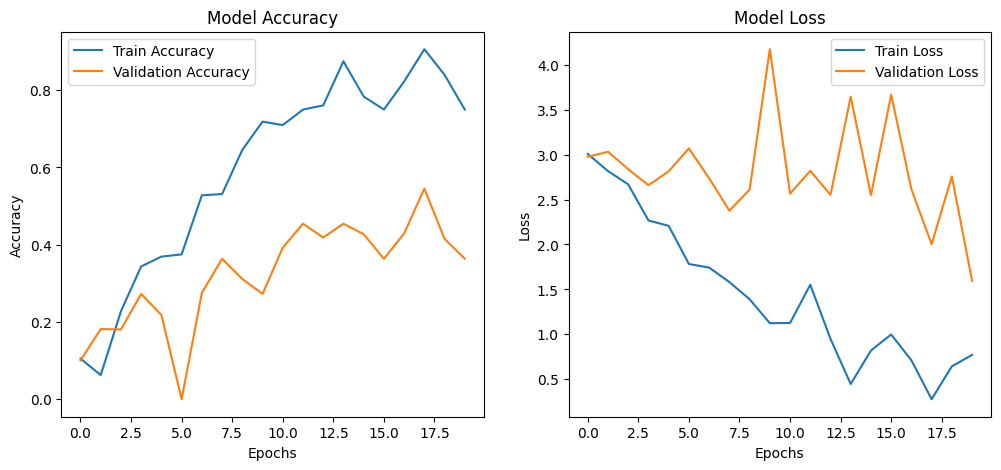

In [30]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [31]:
# Evaluate the model on the validation set (or create a separate test set if available)
test_loss, test_accuracy = vit_model.evaluate(val_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


87/87 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.4091 - loss: 2.6644
Test Accuracy: 42.24%


Processing image: /kaggle/input/workoutexercises-images/barbell biceps curl/barbell biceps curl_1000001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step


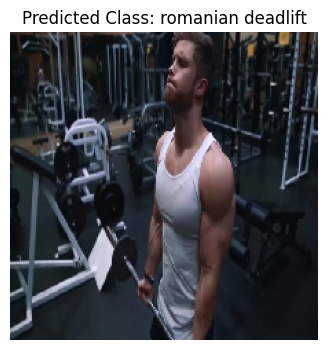

Predicted Class: romanian deadlift
--------------------------------------------------
Processing image: /kaggle/input/workoutexercises-images/barbell biceps curl/barbell biceps curl_1000021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


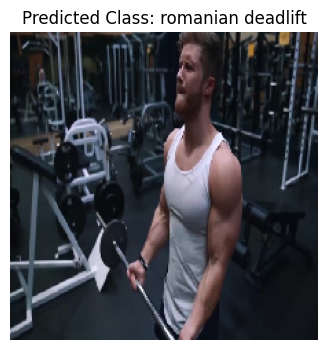

Predicted Class: romanian deadlift
--------------------------------------------------
Processing image: /kaggle/input/workoutexercises-images/barbell biceps curl/barbell biceps curl_1000041.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


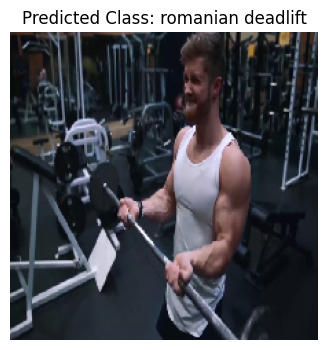

Predicted Class: romanian deadlift
--------------------------------------------------
Processing image: /kaggle/input/workoutexercises-images/bench press/bench press_1000001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


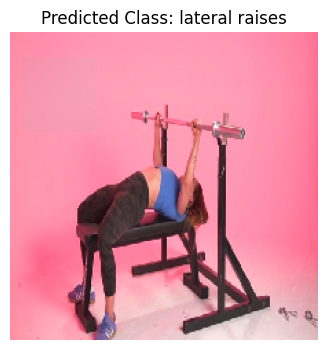

Predicted Class: lateral raises
--------------------------------------------------
Processing image: /kaggle/input/workoutexercises-images/bench press/bench press_1000021.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


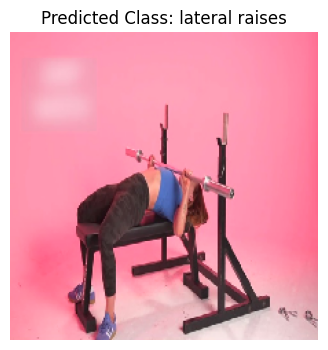

Predicted Class: lateral raises
--------------------------------------------------
Processing image: /kaggle/input/workoutexercises-images/bench press/bench press_1000031.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


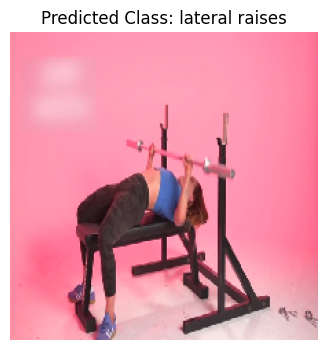

Predicted Class: lateral raises
--------------------------------------------------
Processing image: /kaggle/input/workoutexercises-images/deadlift/deadlift_1000001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


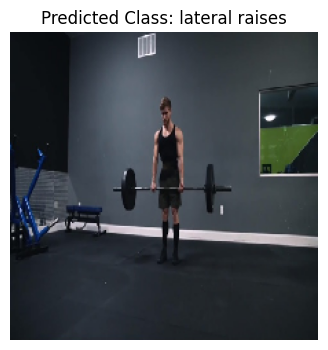

Predicted Class: lateral raises
--------------------------------------------------
Processing image: /kaggle/input/workoutexercises-images/romanian deadlift/romanian deadlift_1000001.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


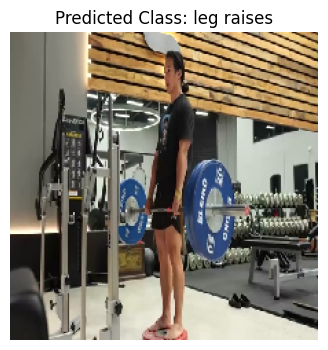

Predicted Class: leg raises
--------------------------------------------------


In [32]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

def load_and_predict(img_path, model, class_names):
    """
    Load an image, preprocess it, make a prediction using the trained model, and display the results.
    """
    # Load the image
    img = image.load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
    
    # Convert the image to an array and normalize
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Make predictions
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions)]

    # Display the image and prediction
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Predicted Class: {predicted_class}")
    plt.show()

    return predicted_class

# Add a list of test image paths
img_paths = [
    '/kaggle/input/workoutexercises-images/barbell biceps curl/barbell biceps curl_1000001.jpg',
    '/kaggle/input/workoutexercises-images/barbell biceps curl/barbell biceps curl_1000021.jpg',
    '/kaggle/input/workoutexercises-images/barbell biceps curl/barbell biceps curl_1000041.jpg',
    '/kaggle/input/workoutexercises-images/bench press/bench press_1000001.jpg',
    '/kaggle/input/workoutexercises-images/bench press/bench press_1000021.jpg',
    '/kaggle/input/workoutexercises-images/bench press/bench press_1000031.jpg',
    '/kaggle/input/workoutexercises-images/deadlift/deadlift_1000001.jpg',
    '/kaggle/input/workoutexercises-images/romanian deadlift/romanian deadlift_1000001.jpg'
]

# Predict and display results for each image
for img_path in img_paths:
    print(f"Processing image: {img_path}")
    predicted_class = load_and_predict(img_path, vit_model, class_names)
    print(f"Predicted Class: {predicted_class}")
    print("-" * 50)


In [33]:

# Save the model
vit_model.save('vit_workout_model.keras')


## Chatbot

In [34]:
!pip install transformers langchain sentence-transformers faiss-cpu


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 21.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 66.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.5/409.5 kB 24.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.8/311.8 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 21.3
    Uninstalling packaging-21.3:
      Successfully uninstalled packaging-21.3
  Attempting uninstall: requests-toolbelt
    Found existing installation: requests-toolbelt 0.10.1
    Uninstalling requests-toolbelt-0.10.1:
      Successfully uninstalled requests-toolbelt-0.10.1
ERROR: pip's dependency resolver does not currently take into account

In [35]:
import pandas as pd

# Reload the original dataset
file_path = "/kaggle/input/gym-exercise-data/megaGymDataset.csv"  # Replace with the correct file path
df = pd.read_csv(file_path)

# Combine relevant columns into the 'content' column for FAISS retrieval
df["content"] = df.apply(
    lambda row: f"Title: {row['Title']}\nDescription: {row['Desc']}\nType: {row['Type']}\nBody Part: {row['BodyPart']}\nEquipment: {row['Equipment']}\nLevel: {row['Level']}",
    axis=1
)

# Save all relevant columns to the metadata file
df.to_csv("fitness_metadata.csv", index=False)


In [43]:
import pandas as pd

# Load the CSV file
file_path = "/kaggle/input/gym-exercise-data/megaGymDataset.csv"  # Replace with the correct file path
try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print(f"Error: File not found at {file_path}. Please check the file path.")
    raise

# Verify required columns exist in the dataset
required_columns = ["Title", "Desc", "Type", "BodyPart", "Equipment", "Level"]
missing_columns = [col for col in required_columns if col not in df.columns]
if missing_columns:
    raise ValueError(f"The following required columns are missing from the dataset: {missing_columns}")

# Combine relevant columns into text blocks for embeddings
df["content"] = df.apply(
    lambda row: (
        f"Title: {row['Title']}\n"
        f"Description: {row['Desc']}\n"
        f"Type: {row['Type']}\n"
        f"Body Part: {row['BodyPart']}\n"
        f"Equipment: {row['Equipment']}\n"
        f"Level: {row['Level']}"
    ),
    axis=1
)

# Save processed data
output_file = "processed_fitness_data.csv"
try:
    df[["content"]].to_csv(output_file, index=False)  # Removed "ID" since it's missing
    print(f"Processed data saved to {output_file}")
except Exception as e:
    print(f"Error saving file: {e}")


Dataset loaded successfully!
Processed data saved to processed_fitness_data.csv


In [44]:
from sentence_transformers import SentenceTransformer
import faiss
import numpy as np
import pandas as pd

# Load processed data
try:
    data = pd.read_csv("processed_fitness_data.csv")
except FileNotFoundError:
    raise FileNotFoundError("The file 'processed_fitness_data.csv' does not exist. Please ensure the file is in the correct directory.")

# Ensure the required column 'content' exists
if "content" not in data.columns:
    raise ValueError("The 'processed_fitness_data.csv' file does not contain the required 'content' column.")

# Generate embeddings using a pre-trained Sentence Transformer
try:
    model = SentenceTransformer("all-MiniLM-L6-v2")  # Lightweight and efficient
    embeddings = model.encode(data['content'].tolist(), show_progress_bar=True)
except Exception as e:
    raise RuntimeError(f"Error generating embeddings: {e}")

# Check if embeddings were generated correctly
if embeddings.shape[0] != len(data):
    raise ValueError("The number of embeddings does not match the number of rows in the dataset.")

# Save embeddings to FAISS index
try:
    index = faiss.IndexFlatL2(embeddings.shape[1])  # L2 (Euclidean distance) index
    index.add(np.array(embeddings))  # Add embeddings to the FAISS index
    faiss.write_index(index, "fitness_index.faiss")  # Save the index to a file
    print("FAISS index created and saved as 'fitness_index.faiss'.")
except Exception as e:
    raise RuntimeError(f"Error saving embeddings to FAISS index: {e}")

# Save metadata (if not already done)
try:
    data.to_csv("fitness_metadata.csv", index=False)
    print("Metadata saved as 'fitness_metadata.csv'.")
except Exception as e:
    raise RuntimeError(f"Error saving metadata: {e}")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/92 [00:00<?, ?it/s]

FAISS index created and saved as 'fitness_index.faiss'.
Metadata saved as 'fitness_metadata.csv'.


In [45]:
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer

# Load FAISS index and metadata
index = faiss.read_index("fitness_index.faiss")
metadata = pd.read_csv("fitness_metadata.csv")

# Load the embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Define a query
query = "What are the best exercises for triceps?"

# Generate query embedding
query_embedding = model.encode([query])

# Search FAISS index
k = 5  # Number of results to return
distances, indices = index.search(query_embedding, k)

# Display results
print("Top matches:")
for i, idx in enumerate(indices[0]):
    print(f"Result {i+1}:")
    print(metadata.iloc[idx]['content'])
    print(f"Distance: {distances[0][i]}")
    print("-" * 50)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Top matches:
Result 1:
Title: Seated triceps press
Description: The seated triceps press is a popular arm-building exercise that targets the triceps with a single dumbbell held by both hands, extending it up behind your head. While you can go surprisingly heavy on this movement, it is usually performed for moderate to high reps, such as 8-12 reps per set or more, as part of the upper-body or arm-focused portion of a workout. If you're going heavy, having someone help get the weight into position is a good idea.
Type: Strength
Body Part: Triceps
Equipment: Dumbbell
Level: Intermediate
Distance: 0.8773298263549805
--------------------------------------------------
Result 2:
Title: Machine triceps extension-
Description: The machine triceps extension is a popular exercise to build size and strength in the triceps muscles. It approximates the motion of a free-weight skullcrusher, but uses a selectorized weight-stack or plate-loaded machine. Machine triceps extensions are often done for mod

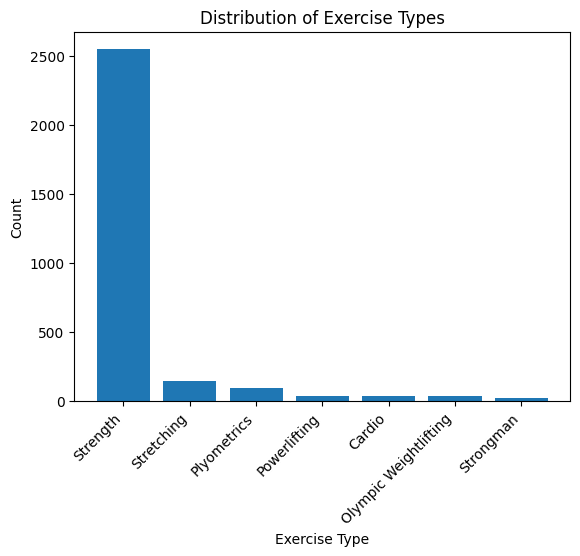

In [46]:
import matplotlib.pyplot as plt

# Plot class distribution
type_counts = df['Type'].value_counts()

plt.bar(type_counts.index, type_counts.values)
plt.xlabel("Exercise Type")
plt.ylabel("Count")
plt.title("Distribution of Exercise Types")
plt.xticks(rotation=45, ha="right")
plt.show()


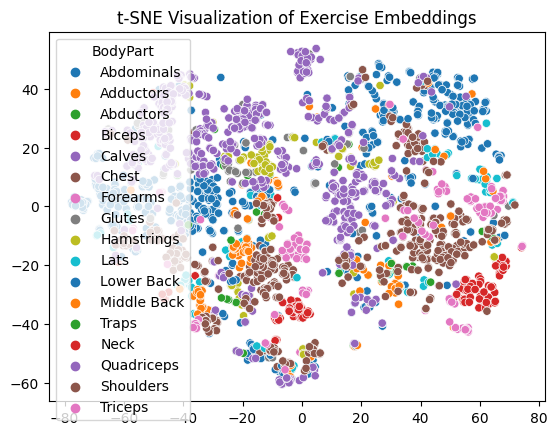

In [47]:
from sklearn.manifold import TSNE
import seaborn as sns

# Reduce embeddings to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Visualize embeddings with class labels (e.g., BodyPart)
df['BodyPart'] = df['BodyPart'].fillna("Unknown")
sns.scatterplot(
    x=reduced_embeddings[:, 0],
    y=reduced_embeddings[:, 1],
    hue=df['BodyPart'],
    palette="tab10",
    legend="full"
)
plt.title("t-SNE Visualization of Exercise Embeddings")
plt.show()


In [48]:
import faiss
import pandas as pd
from sentence_transformers import SentenceTransformer

# Load FAISS index and metadata
index = faiss.read_index("fitness_index.faiss")
metadata = pd.read_csv("fitness_metadata.csv")

# Query the FAISS index
model = SentenceTransformer("all-MiniLM-L6-v2")
query = "What are the best exercises for triceps?"
query_embedding = model.encode([query])

k = 5  # Number of nearest neighbors
distances, indices = index.search(query_embedding, k)

# Extract BodyPart from the 'content' column
def extract_bodypart(content):
    """Extract the body part from the content."""
    for line in content.split('\n'):
        if line.startswith("Body Part:"):
            return line.replace("Body Part:", "").strip()
    return None  # Return None if 'Body Part' is not found

# Retrieve and process results
retrieved_bodyparts = []
for idx in indices[0]:
    content = metadata.iloc[idx]["content"]
    bodypart = extract_bodypart(content)
    retrieved_bodyparts.append(bodypart)

# Calculate Precision@k
precision_at_k = sum([1 if bp == "Triceps" else 0 for bp in retrieved_bodyparts]) / k

print(f"Precision@{k}: {precision_at_k}")


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Precision@5: 1.0


In [49]:
import pandas as pd
import faiss
from sentence_transformers import SentenceTransformer

# Load FAISS index and metadata
index = faiss.read_index("fitness_index.faiss")
metadata = pd.read_csv("fitness_metadata.csv")

# Load the embedding model
model = SentenceTransformer("all-MiniLM-L6-v2")

# Function to retrieve and display results
def retrieve_exercises(query, k=2):
    # Generate query embedding
    query_embedding = model.encode([query])
    
    # Search FAISS index
    distances, indices = index.search(query_embedding, k)
    
    # Display results
    results = []
    print("\nTop matches:")
    for i, idx in enumerate(indices[0]):
        result = metadata.iloc[idx]['content']
        results.append(result)
        print(f"Result {i+1}:")
        print(result)
        print(f"Distance: {distances[0][i]}")
        print("-" * 50)
    return results

# Infinite chatbot loop
print("Fitness Chatbot: Ask me about fitness exercises! (type 'exit' to quit)\n")
while True:
    user_query = input("You: ")
    if user_query.lower() in ['exit', 'quit']:
        print("Chatbot: Goodbye!")
        break
    retrieve_exercises(user_query)


Fitness Chatbot: Ask me about fitness exercises! (type 'exit' to quit)



You:  Chest exercise


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Top matches:
Result 1:
Title: Machine chest press
Description: The machine chest press is a machine-based exercise targeting the chest. It approximates the motion of a bench press but is usually performed facing forward and seated upright. Many machines offer multiple grip options, such as overhand, neutral (palms facing), or underhand. The chest press is often performed for moderate to high reps, such as 8-12 reps per set or more, as part of a pre-exhaust or muscle-building upper-body workout.
Type: Strength
Body Part: Chest
Equipment: Machine
Level: Intermediate
Distance: 0.7597191333770752
--------------------------------------------------
Result 2:
Title: Exercise ball chest stretch
Description: The exercise ball chest stretch is a simple stretch for the pectoral muscles that can be made more dynamic with help from a medicine ball. It can work in a dynamic warm-up, paired with movements in a workout, or as part of a cool-down or recovery strategy. If the stretch causes pain in the

You:  Back exercise


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Top matches:
Result 1:
Title: Back extension
Description: The back extension is an exercise used to build lower back strength that also targets the hamstrings and glutes. It is often performed on a 45-degree bench with the feet anchored. Unweighted back extensions are often performed for high reps, such as 15-20 reps or more, but the movement can also be performed with added weight in lower rep ranges, such as 8-12 reps per set.
Type: Strength
Body Part: Lower Back
Equipment: Body Only
Level: Intermediate
Distance: 0.7357985973358154
--------------------------------------------------
Result 2:
Title: Back Extension - Gethin Variation
Description: The back extension is an exercise used to build lower back strength that also targets the hamstrings and glutes. It is often performed on a 45-degree bench with the feet anchored. Unweighted back extensions are often performed for high reps, such as 15-20 reps or more, but the movement can also be performed with added weight in lower rep rang

You:  exit


Chatbot: Goodbye!


In [50]:
import os
import faiss
import pandas as pd

# Directory to save files
output_dir = "fitness_model_files"
os.makedirs(output_dir, exist_ok=True)

# Save FAISS index
faiss.write_index(index, os.path.join(output_dir, "fitness_index.faiss"))

# Save metadata
metadata.to_csv(os.path.join(output_dir, "fitness_metadata.csv"), index=False)

# Save SentenceTransformer model
model.save(output_dir)

print(f"Model and index saved to {output_dir}")


Model and index saved to fitness_model_files


In [51]:
import os
import shutil

# Create a directory to store the files
download_dir = "download_files"
os.makedirs(download_dir, exist_ok=True)

# List of required files
required_files = [
    "fitness_index.faiss",               # FAISS index file
    "fitness_metadata.csv",              # Metadata file
    "processed_fitness_data.csv",        # Optional processed data file
    "vit_workout_model.keras",           # Optional Vision Transformer model
    "nn_model.keras"                     # Optional neural network model
]

# Add Sentence Transformer model files
sentence_transformer_dir = "fitness_model_files"
if os.path.exists(sentence_transformer_dir):
    shutil.copytree(sentence_transformer_dir, os.path.join(download_dir, "fitness_model_files"))

# Copy required files to the download directory
for file in required_files:
    if os.path.exists(file):
        shutil.copy(file, os.path.join(download_dir, file))
    else:
        print(f"File not found: {file} (Skipping)")

# Compress the directory into a .zip file
shutil.make_archive("download_files", "zip", download_dir)
print("Files compressed into download_files.zip")

# Provide a download link
from IPython.display import FileLink
FileLink("download_files.zip")


Files compressed into download_files.zip


/kaggle/working/download_files.zip